In [1]:
IMG_PATH = './Rock-image-patches'
CSV_RGB = './colors_RGB2.csv'
CSV_LAB = './colors_LAB2.csv'

MAX_SIZE = (512, 512)
CLUSTERS = 4
images_per_type_to_plot = 1

#### Imports

In [10]:
import os
from skimage import io, color
from PIL import Image
import numpy as np
import cv2

def load_images_from_directory(path, max_size=None):
    x_rgb = []; x_lab = []; y = []; files = [];
    for folder in os.listdir(path):
        if(os.path.isfile(folder)):
            print(os.path.join(path,folder), 'was removed')
            continue
        for file in os.listdir(os.path.join(path,folder)):
            if(not file.lower().endswith(('.png', '.jpg', '.jpeg'))):
                print(os.path.join(path,folder,file), 'was removed')
                continue
            if max_size == None:
                # pilmode_doc=https://pillow.readthedocs.io/en/3.0.x/handbook/concepts.html
                img = io.imread(os.path.join(path,folder,file), pilmode='RGB')
            else:
                img = Image.open(os.path.join(path,folder,file)).convert('RGB')
                img.thumbnail(max_size, Image.ANTIALIAS)
                img = np.array(img)
            x_rgb.append(img)
            x_lab.append(color.rgb2lab(img)) # illuminant='D65'
            y.append(folder)
            files.append(file)
        print(folder, "images were loaded")
    return (x_rgb, x_lab, y, files)

def get_dominant_colors(img):
    reshape = img.reshape((img.shape[0] * img.shape[1], img.shape[2]))
    cluster = KMeans(n_clusters=CLUSTERS).fit(reshape)
    lb = np.arange(0, len(np.unique(cluster.labels_))+1) # Get the number of different clusters
    (hist, _) = np.histogram(cluster.labels_, bins = lb) # create histogram
    hist = hist.astype("float"); hist /= hist.sum() # normalize
    colors = sorted([(percent, color) for (percent, color) in zip(hist, cluster.cluster_centers_)])
    features = []
    for (percent, color) in colors:
        features.extend(color)
        features.append(percent)
    return features

def get_dominants_plot(features):
    rect = np.zeros((50, 300, 3), dtype=np.uint8)
    start = 0
    for i in range(4):
        color_ = np.array(features[i*4:i*4+3])
        percent = features[i*4+3]
        end = start + (percent * 300)
        cv2.rectangle(rect, (int(start), 0), (int(end), 50), color_.astype("uint8").tolist(), -1)
        start = end
    return rect

def get_avg_plot(img):
    average = img.mean(axis=0).mean(axis=0)
    avg_patch = np.ones(shape=img.shape, dtype=np.uint8)*np.uint8(average)
    return avg_patch

### 1. Loading data

In [3]:
x_rgb, x_lab, y, files = load_images_from_directory(IMG_PATH, MAX_SIZE)

Granodiorite images were loaded
./Rock-image-patches/.DS_Store was removed
Granite images were loaded
Diorite images were loaded
Monzodiorite images were loaded
Tonalite images were loaded
Gabbro images were loaded


In [4]:
import pandas as pd
print('Data visualization')
classes, indices, counts = np.unique(y, return_counts=True, return_index=True)
df = pd.DataFrame({'Classes': classes, 'Counts': counts, 'Start index': indices})
df.sort_values(by=['Start index'], ascending=True, ignore_index='x')

Data visualization


,Classes,Counts,Start index
0,Granodiorite,70,0
1,Granite,70,70
2,Diorite,78,140
3,Monzodiorite,65,218
4,Tonalite,75,283
5,Gabbro,65,358


### 2. Determining the best k number for kmeans

Iterating a range number of clusters for kmeans

In [5]:
from sklearn.cluster import KMeans

print('Image rgb: Gabbro/'+files[415], x_rgb[415].shape)
reshape = x_rgb[415].reshape((x_rgb[415].shape[0] * x_rgb[415].shape[1], x_rgb[415].shape[2]))

#print('Image lab: Gabbro/', files[415], x_lab[415].shape)
#reshape = x_lab[415].reshape((x_lab[415].shape[0] * x_lab[415].shape[1], x_lab[415].shape[2]))

Nclusters = range(2, 20)
score = []; distortions = []
for n in Nclusters:
    k = KMeans(n_clusters=n)
    k.fit(reshape)
    distortions.append(k.inertia_)
    score.append(k.score(reshape))
    print('Kmeans was trained with k =', n)

Image rgb: Gabbro/ 10715B_P1_Cleaned_02_04.png (470, 512, 3)
Kmeans was trained with k = 2
Kmeans was trained with k = 3
Kmeans was trained with k = 4
Kmeans was trained with k = 5
Kmeans was trained with k = 6
Kmeans was trained with k = 7
Kmeans was trained with k = 8
Kmeans was trained with k = 9
Kmeans was trained with k = 10
Kmeans was trained with k = 11
Kmeans was trained with k = 12
Kmeans was trained with k = 13
Kmeans was trained with k = 14
Kmeans was trained with k = 15
Kmeans was trained with k = 16
Kmeans was trained with k = 17
Kmeans was trained with k = 18
Kmeans was trained with k = 19


Plotting the Elbow curve

In [6]:
# Plot configuration
import matplotlib.pyplot as plt
plt.rc('font', family='Times New Roman')
plt.rc('axes', titlesize=13)
plt.rc('font', size=13)

/Users/sarah/opt/miniconda3/envs/rocks/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


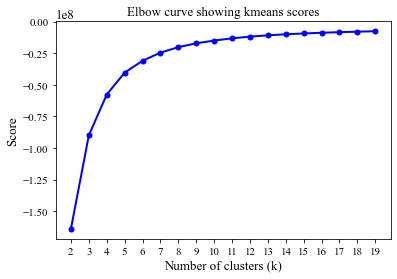

In [7]:
# Plot of Elbow curve with the Kmeans scores
plt.plot(Nclusters, score, 'bo-', linewidth=2,markersize=5)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Score')
plt.title('Elbow curve showing kmeans scores')
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.axes().set_xticks(Nclusters)
#plt.savefig('Elbow curve.png', dpi=300)
plt.show()

/Users/sarah/opt/miniconda3/envs/rocks/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


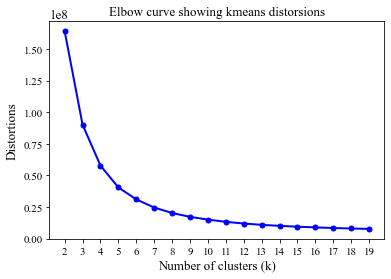

In [8]:
plt.plot(Nclusters, distortions, 'bo-', linewidth=2,markersize=5)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Distortions')
plt.title('Elbow curve showing kmeans distorsions')
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.axes().set_xticks(Nclusters)
#plt.savefig('Elbow curve - distorsions.png', dpi=300)
plt.show()

### 3. Extracting dominant colors from images

In [11]:
extracted_rgb = []
extracted_lab = []

for rgb, lab in zip(x_rgb, x_lab):
    features = get_dominant_colors(rgb)
    extracted_rgb.append(features)
    
    features = get_dominant_colors(lab)
    extracted_lab.append(features)

Plotting dominant colors in sample images

Diorite/11825B_P2_02_02.png
Gabbro/12719J_P2_03_02.png
Granite/11826E_P2_02_02.png
Granodiorite/10715M_P2_01_02.png
Monzodiorite/10715D_P2_02_02.png
Tonalite/12717D_P2_Cleaned_01_02.png


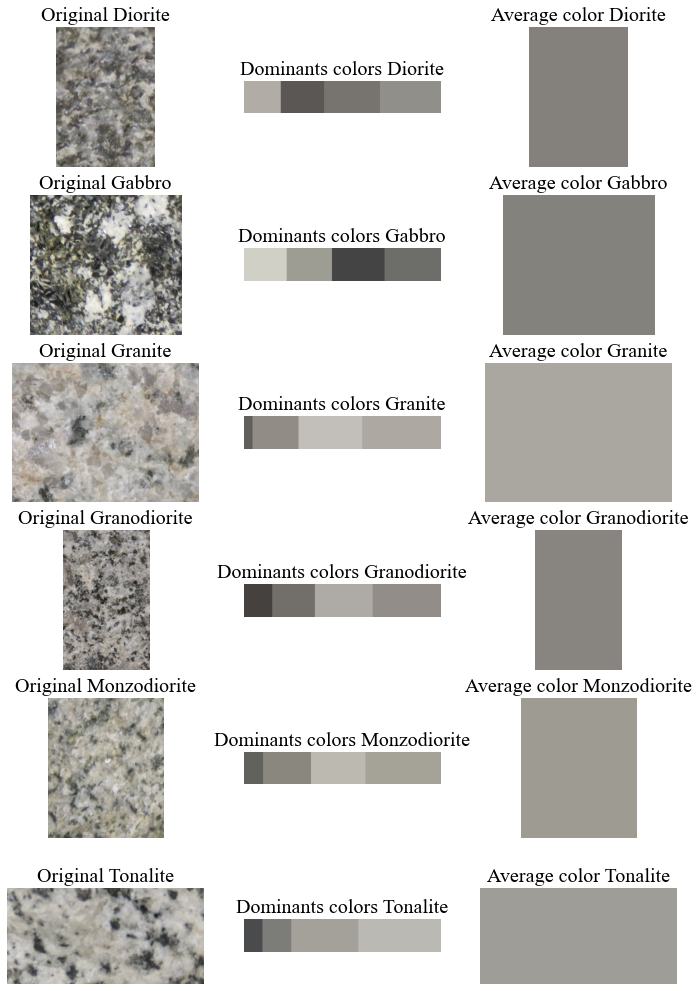

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


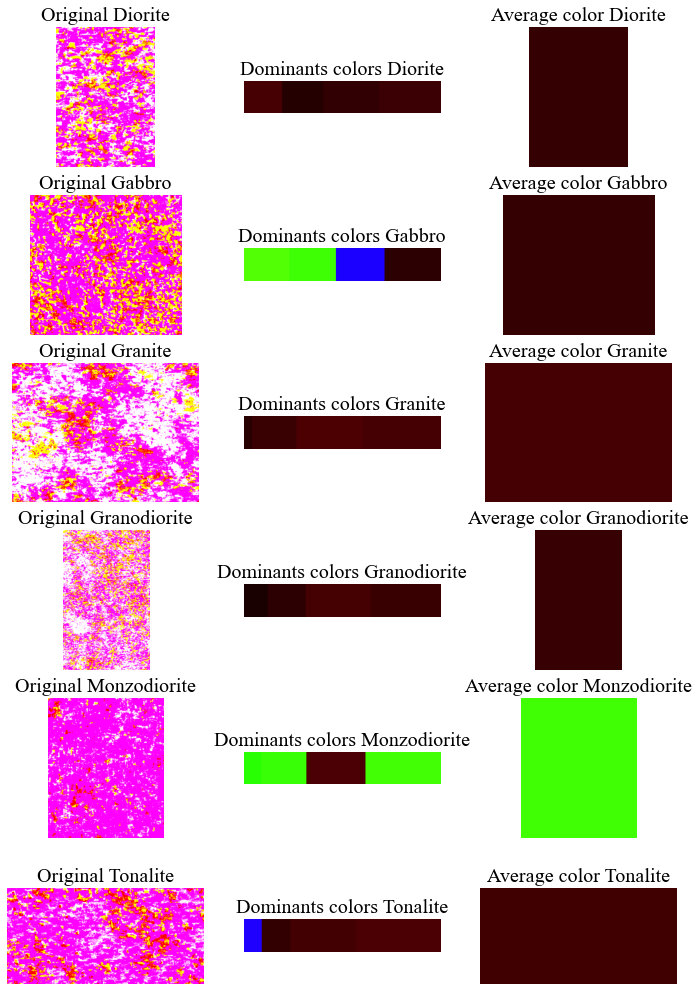

In [16]:
images_rgb = []
images_lab = []
tittles = []
tittle2 = []

for idx in indices:
    for i in range(0+1, images_per_type_to_plot+1):
        images_rgb.append(x_rgb[idx+i+1])
        images_rgb.append(get_dominants_plot(extracted_rgb[idx+i+1]))
        images_rgb.append(get_avg_plot(x_rgb[idx+i+1]))
        images_lab.append(x_lab[idx+i+1])
        images_lab.append(get_dominants_plot(extracted_lab[idx+i+1]))
        images_lab.append(get_avg_plot(x_lab[idx+i+1]))
        tittles.append('Original ' + y[idx+i+1])
        tittles.append('Dominants colors ' + y[idx+i+1])
        tittles.append('Average color ' + y[idx+i+1])
        tittles2.append('Original ' + y[idx+i+1])
        tittles2.append('Dominants colors ' + y[idx+i+1])
        tittles2.append('Average color ' + y[idx+i+1])
        print(y[idx+i+1]+'/'+files[idx+i+1])

plt.rc('font', family='Times New Roman')
plt.rc('axes', titlesize=20)

rows = len(indices)*images_per_type_to_plot
columns = int(len(images_rgb) / rows)

fig, plots = plt.subplots(rows, columns, figsize=(12,18*images_per_type_to_plot))
for row in plots:
    for ax in row:
        ax.imshow(images_rgb.pop(0))
        ax.set_title(tittles.pop(0))
        ax.axis('off')
#plt.savefig('Color extraction RGB.png', dpi=300)
plt.show(fig)

fig, plots = plt.subplots(rows, columns, figsize=(12,18*images_per_type_to_plot))
for row in plots:
    for ax in row:
        ax.imshow(images_lab.pop(0))
        ax.set_title(tittles2.pop(0))
        ax.axis('off')
#plt.savefig('Color extraction LAB.png', dpi=300)
plt.show(fig)

### 4. Add data to CSV

In [17]:
rgb_df = pd.DataFrame(extracted_rgb, files)
rgb_df[16] = y
rgb_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
11830I_P2_01_02.png,96.863495,93.120677,92.137694,0.125464,200.394377,197.333051,192.767428,0.243866,138.596007,134.568425,132.122252,0.269400,170.556010,166.601406,162.708905,0.361271,Granodiorite
12720V_P2.JPG,90.321143,89.039617,87.438898,0.105520,199.928664,195.011638,190.618280,0.222585,138.270638,134.907807,131.849897,0.279763,168.682666,164.270031,160.146278,0.392132,Granodiorite
10715M_P2_01_02.png,69.257787,65.977336,63.423675,0.143382,114.174083,110.441626,106.189028,0.217934,174.424147,170.529182,166.391013,0.292938,146.105059,141.859696,137.525080,0.345746,Granodiorite
12723M_P2_01_02.png,73.755892,72.437105,73.044577,0.158644,129.849342,125.630913,123.618804,0.223063,199.199254,195.961496,191.878821,0.290065,166.744538,162.545434,159.189914,0.328228,Granodiorite
11830I_P2_01_01.png,104.618070,101.480895,94.149582,0.138466,142.848787,139.374383,134.163519,0.248368,200.662925,198.113184,196.144054,0.265465,172.930810,169.863381,166.608114,0.347702,Granodiorite
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12717C_P2_01_03.png,179.957356,178.384851,175.705786,0.156950,87.201492,82.418190,80.021837,0.242280,148.696788,146.353478,143.711033,0.278017,117.698734,114.388351,112.413532,0.322754,Gabbro
12717B_P2_03_01.png,190.041433,186.515886,174.816494,0.125535,157.094767,154.020051,146.875203,0.262109,109.985630,106.884044,102.758192,0.277948,132.315799,129.121431,124.002784,0.334408,Gabbro
12717B_P2_01_04.png,176.787515,173.997478,168.639090,0.092697,147.740024,144.810928,140.430892,0.235526,105.821297,101.853249,98.399612,0.317989,125.504997,121.966397,118.150792,0.353787,Gabbro
10719CC_P2.jpg,185.207937,183.066042,178.629638,0.154494,147.538166,145.943135,142.065968,0.259395,80.410761,78.243972,73.429386,0.269728,112.511193,110.805618,106.425066,0.316382,Gabbro


In [19]:
lab_df = pd.DataFrame(extracted_lab, files)
lab_df[-1] = y
lab_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,-1
11830I_P2_01_02.png,39.389532,1.538687,0.696125,0.119542,79.502115,0.175901,2.884650,0.256421,55.961986,1.133098,1.684914,0.262521,68.168502,0.727964,2.583313,0.361517,Granodiorite
12720V_P2.JPG,36.559662,0.279757,0.837766,0.093925,78.504320,0.897993,2.987904,0.246676,55.190234,0.696653,1.869909,0.254501,66.831071,0.828618,2.708050,0.404898,Granodiorite
10715M_P2_01_02.png,26.614789,1.012896,1.708079,0.122985,44.374148,0.666609,2.855678,0.190504,69.338989,0.603026,2.793010,0.330196,57.734468,0.782428,2.827986,0.356316,Granodiorite
12723M_P2_01_02.png,30.006722,0.816405,-0.420881,0.148248,51.489694,1.263941,1.430180,0.207770,78.757961,0.356180,2.652569,0.314195,65.993980,0.992120,2.230391,0.329786,Granodiorite
11830I_P2_01_01.png,42.042145,-0.115496,4.479466,0.123494,57.005008,0.359963,3.321333,0.237210,79.656766,0.495859,1.502738,0.286960,68.932388,0.528619,2.099385,0.352336,Granodiorite
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12717C_P2_01_03.png,72.340986,-0.043466,1.985683,0.169872,35.090292,1.657161,1.877502,0.230938,60.293765,0.403976,1.776862,0.277144,48.006337,0.972996,1.464154,0.322046,Gabbro
12717B_P2_03_01.png,75.564562,-1.000849,7.004312,0.126398,63.625749,-0.251382,4.280002,0.263137,45.346835,0.534385,2.477168,0.278310,54.175269,0.292576,3.057100,0.332155,Gabbro
12717B_P2_01_04.png,70.969876,-0.105884,3.473141,0.096949,60.058045,0.223828,2.807210,0.238088,43.332157,0.986376,2.321374,0.314807,51.322502,0.621352,2.558937,0.350156,Gabbro
10719CC_P2.jpg,73.599076,-0.128173,2.730437,0.174059,32.671374,0.005903,3.004154,0.246608,59.263592,-0.137952,2.311699,0.266977,45.666973,-0.152505,2.703167,0.312356,Gabbro


In [ ]:
rgb_df.to_csv(CSV_RGB, header=None)
lab_df.to_csv(CSV_LAB, header=None)